In [1]:
import numpy as np
import pickle
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets
from ipywidgets import interact, IntSlider
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Function to plot the skeleton
def plot_skeleton(joints, ax, c, joint_names):
    # Define the connections between joints
    skeleton_connections = [
        ('pelvis', 'spine1'),('pelvis', 'right_hip'), ('pelvis','left_hip'), ('spine1', 'spine2'), ('spine2', 'spine3'), ('spine3', 'neck'),
        ('neck', 'head'), ('spine3', 'left_collar'), ('spine3', 'right_collar'),
        ('left_collar', 'left_shoulder'), ('right_collar', 'right_shoulder'),
        ('left_shoulder', 'left_elbow'), ('right_shoulder', 'right_elbow'),
        ('left_elbow', 'left_wrist'), ('right_elbow', 'right_wrist'),
        ('left_hip', 'left_knee'), ('right_hip', 'right_knee'),
        ('left_knee', 'left_ankle'), ('right_knee', 'right_ankle'),
        ('left_ankle', 'left_foot'), ('right_ankle', 'right_foot'),
        ('head', 'jaw'), ('jaw', 'left_eye_smplhf'), ('jaw', 'right_eye_smplhf'),
        ('left_wrist', 'left_thumb1'), ('left_wrist', 'left_index1'), ('left_wrist', 'left_middle1'),
        ('left_wrist', 'left_ring1'), ('left_wrist', 'left_pinky1'),
        ('right_wrist', 'right_thumb1'), ('right_wrist', 'right_index1'), ('right_wrist', 'right_middle1'),
        ('right_wrist', 'right_ring1'), ('right_wrist', 'right_pinky1'), ('left_thumb1', 'left_thumb2'),
        ('left_index1', 'left_index2'), ('left_middle1', 'left_middle2'), ('left_ring1', 'left_ring2'),
        ('left_pinky1', 'left_pinky2'), ('right_thumb1', 'right_thumb2'), ('right_index1', 'right_index2'),
        ('right_middle1', 'right_middle2'), ('right_ring1', 'right_ring2'), ('right_pinky1', 'right_pinky2'),
        ('left_thumb2', 'left_thumb3'), ('left_index2', 'left_index3'), ('left_middle2', 'left_middle3'),
        ('left_ring2', 'left_ring3'), ('left_pinky2', 'left_pinky3'), ('right_thumb2', 'right_thumb3'),
        ('right_index2', 'right_index3'), ('right_middle2', 'right_middle3'), ('right_ring2', 'right_ring3'),
        ('right_pinky2', 'right_pinky3')
    ]

    # Convert joint names to indices
    joint_indices = {name: i for i, name in enumerate(joint_names)}

    for joint1_name, joint2_name in skeleton_connections:
        joint1_index = joint_indices[joint1_name]
        joint2_index = joint_indices[joint2_name]

        joint1 = joints[joint1_index]
        joint2 = joints[joint2_index]

        ax.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], [joint1[2], joint2[2]], color=c)

In [3]:
def vis_one_data_point(leader):
    ''' leader and follower should have shapes (T, 165) '''
    ''' will visualize a single data_point '''  
    # Example data
    T = leader.shape[0]  # Number of frames

    # if joints_data is a tensor, convert
    if torch.is_tensor(leader):
        joints_data = leader.reshape(-1, 55, 3).detach().cpu().numpy()
    else:
        joints_data = leader.reshape(-1, 55, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # List of joint names
    joint_names = [
        'pelvis', 'left_hip', 'right_hip', 'spine1', 'left_knee', 'right_knee',
        'spine2', 'left_ankle', 'right_ankle', 'spine3', 'left_foot', 'right_foot',
        'neck', 'left_collar', 'right_collar', 'head', 'left_shoulder',
        'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist',
        'jaw', 'left_eye_smplhf', 'right_eye_smplhf', 'left_index1', 'left_index2',
        'left_index3', 'left_middle1', 'left_middle2', 'left_middle3',
        'left_pinky1', 'left_pinky2', 'left_pinky3', 'left_ring1', 'left_ring2',
        'left_ring3', 'left_thumb1', 'left_thumb2', 'left_thumb3', 'right_index1',
        'right_index2', 'right_index3', 'right_middle1', 'right_middle2',
        'right_middle3', 'right_pinky1', 'right_pinky2', 'right_pinky3',
        'right_ring1', 'right_ring2', 'right_ring3', 'right_thumb1',
        'right_thumb2', 'right_thumb3'
    ]

    def plot_frame(t):
        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        
        # Plot joints
        ax.scatter(joints_data[t, :, 0], joints_data[t, :, 1], joints_data[t, :, 2], c='r')
        
        # Plot skeleton
        plot_skeleton(joints_data[t], ax, 'r', joint_names)

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Skeleton Visualization - Frame {t+1}')

        xmin = np.min(joints_data[:, :, 0])
        xmax = np.max(joints_data[:, :, 0])
        ymin = np.min(joints_data[:, :, 1])
        ymax = np.max(joints_data[:, :, 1])
        zmin = np.min(joints_data[:, :, 2])
        zmax = np.max(joints_data[:, :, 2])


        # Set fixed axis limits
        ax.set_xlim([xmin, xmax])  # Adjust xmin and xmax according to your data
        ax.set_ylim([ymin, ymax])  # Adjust ymin and ymax according to your data
        ax.set_zlim([zmin, zmax])  # Adjust zmin and zmax according to your data



    # Function to update the plot for the animation
    def update(t):
        ax.clear()  # Clear the current figure
        plot_frame(t)

    ani = animation.FuncAnimation(fig, update, frames=range(leader.shape[0]), repeat=False)


    return ani

In [4]:
follower = np.load('data/motion/pos3d/train/Ballet_001_001_00.npy')
leader = np.load('data/motion/pos3d/train/Ballet_001_001_01.npy')

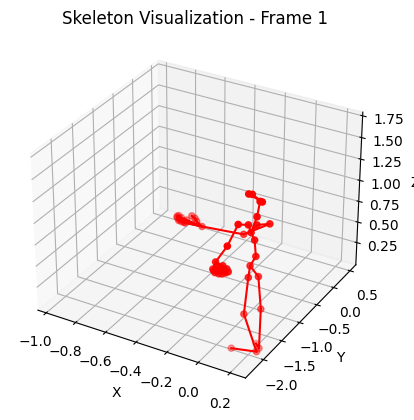

In [69]:
ani = vis_one_data_point(leader[:300])

In [70]:
ani.save('leader.gif', writer='imagemagick', fps=30)

MovieWriter imagemagick unavailable; using Pillow instead.


In [8]:
follower_rot = np.load('data/motion/rotmat/train/Ballet_001_001_00.npy')
leader_rot = np.load('data/motion/rotmat/train/Ballet_001_001_01.npy')

In [9]:
def convert_rotmat_pos3d(rotmat):
    '''rotmat (T, 498)'''
    root_posistions = rotmat[:, :3]
    rotation_matrices = rotmat[:, 3:].reshape(-1, 55, 3, 3)

    global_joint_positions = np.zeros((rotmat.shape[0], 55, 3))
    
    for t in range(rotmat.shape[0]):
        for j in range(55):
            global_joint_positions[t, j] = root_posistions[t] + rotation_matrices[t, j]@

(2293, 498)

In [71]:
def rotmat_to_pos_3d(rotmats):
    T = rotmats.shape[0]
    assert rotmats.shape[1] == 498, "Input must have shape (T, 498)"
    
    # Number of joints
    num_joints = 55
    
    # Extract root positions (first 3 elements in each time step)
    root_positions = rotmats[:, :3]  # Shape: (T, 3)
    
    # Extract rotation matrices for joints (remaining 495 elements)
    rotation_matrices = rotmats[:, 3:].reshape(T, num_joints, 3, 3)  # Shape: (T, 55, 3, 3)
    
    # Initialize array for global 3D positions
    pos_3d = np.zeros((T, num_joints * 3))  # Shape: (T, 165)
    
    # Assume a standardized skeleton structure with joint offsets (example values)
    # Adjust these offsets based on your specific skeleton structure
    joint_offsets = np.ones((num_joints, 3))/100
    
    for t in range(T):
        # Compute global positions for each joint
        for j in range(num_joints):
            if j == 0:
                # Root joint position
                pos_3d[t, j*3:(j+1)*3] = root_positions[t]
            else:
                # Compute global position of joint j based on parent joint's global position and rotation matrix
                parent_global_pos = pos_3d[t, (j-1)*3:j*3]
                pos_3d[t, j*3:(j+1)*3] = parent_global_pos + rotation_matrices[t, j] @ joint_offsets[j]
    
    return pos_3d

In [72]:
pos_3d_leader = rotmat_to_pos_3d(leader_rot)

In [73]:
pos_3d_leader.shape

(2293, 165)

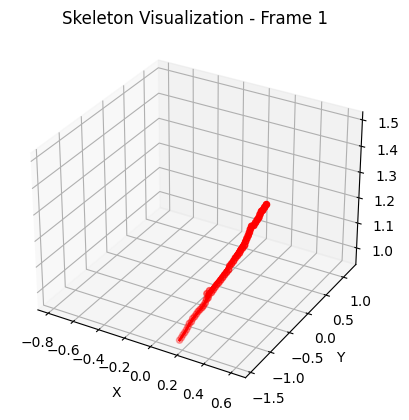

In [74]:
ani_1 = vis_one_data_point(pos_3d_leader[:300, :])

In [68]:
ani_1.save('converted_rotmat_3d.gif', writer=animation.PillowWriter(fps=30))